#Introduction


**Fashion MNIST** is a dataset of Zalando's article images instead of hand-written digits like the old MNIST. This dataset contains **70.000** images: it consists of a training set of **60.0000** images and a test set of **10.000** images. Each image is a 28x28 grayscale associated with a label from 10 different labels.

# Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from matplotlib.pyplot import figure, show
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import matplotlib.style as style
from sklearn.model_selection import train_test_split
from keras.layers import Input, Concatenate,concatenate, Dense, Embedding, Dropout, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, History
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D, Activation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.layers.normalization import BatchNormalization
from matplotlib import pyplot as plt
from keras import backend as K
from keras.optimizers import SGD
from keras.models import Model
import seaborn as sns
import numpy as np
import argparse
import time
import glob
import cv2
import numpy
import os
import glob
import sys
import os
import json
import pprint
import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
!curl -L -O https://www.dropbox.com/s/heyqll2my8uw0tq/fashionmnist.zip
!unzip  fashionmnist.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1034    0  1034    0     0    839      0 --:--:--  0:00:01 --:--:--  2051
100 68.7M  100 68.7M    0     0  20.1M      0  0:00:03  0:00:03 --:--:-- 44.9M
Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [3]:
#Load training and test data using dataframes from Pandas.
train = pd.read_csv("fashion-mnist_train.csv") 
test = pd.read_csv("fashion-mnist_test.csv")
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [0]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

X = train.iloc[:,1:]
Y = train.iloc[:,:1]
X_test = test.iloc[:,1:]
Y_test = test.iloc[:,:1]

#Normalization
X = np.asarray(X).reshape(X.shape[0],img_rows,img_cols,1)
X_test = np.asarray(X_test).reshape(X_test.shape[0],img_rows,img_cols,1)
X = (255. - X) / 255.
X_test = (255. - X_test) / 255.

#Number of classes
classes = len(Y['label'].value_counts())



In [5]:
print("Number of features: ", X.shape[1])
print("Number of train samples: ", X.shape[0])
print("Number of test samples: ", X_test.shape[0])

Number of features:  28
Number of train samples:  60000
Number of test samples:  10000


We can plot the different classes and in the following figures we can see that our dataset is balanced.

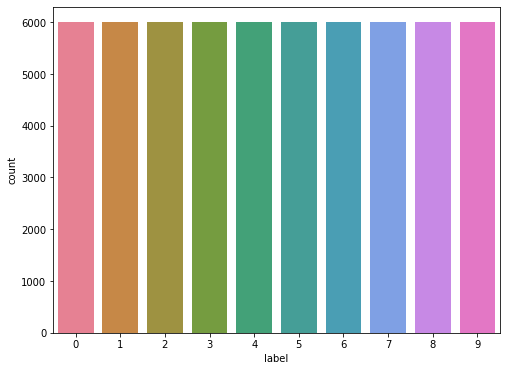

In [6]:
figure(figsize=(8,6))
ax = sns.countplot(x=Y['label'], data=Y, palette="husl")


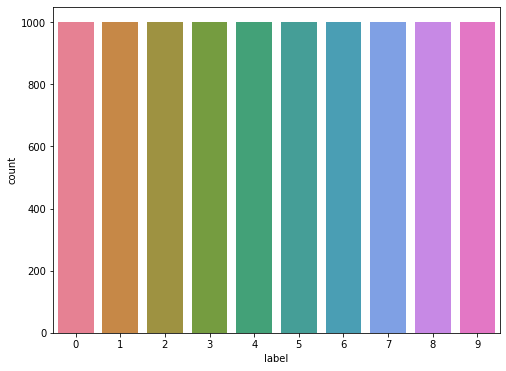

In [7]:
figure(figsize=(8,6))
ax = sns.countplot(x=Y_test['label'], data=Y_test,palette="husl")

Let's visualize a sample.

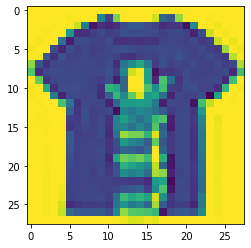

In [8]:
sample = X[13,:].reshape(28,28)
plt.imshow(sample)
plt.show()

#Training

Separate into train / test / validation sets.

In [0]:
Y_test = to_categorical(Y_test)
Y = to_categorical(Y)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, stratify=Y, test_size=0.2,  random_state=66)

## Parameters

In [0]:
lrr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, epsilon=1e-3, mode='min')
early_stopping = EarlyStopping(monitor='val_loss',patience=5,verbose=0, mode='auto')
checkpoint = ModelCheckpoint("checkpoint.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
batch_size = 32
epochs = 10

## Advanced model

This model is a simple CNN classifier with only 4 convolution layers, max-pooling layer and finally, a dense layer. Moreover, a dropout of 25% is added and BatchNormalization.

In [0]:
def model_advanced(classes=classes,optimizer='adam'):
  kernel_size = (3,3)
  dropout = 0.25
  pool_size = (2,2)
  inputs = Input(shape=(img_rows, img_cols, 1))
  y = Conv2D(filters=32, kernel_size=kernel_size,activation='relu',padding='same')(inputs)
  y = BatchNormalization()(y)
  y = Conv2D(filters=32, kernel_size=kernel_size,activation='relu',padding='same')(y)
  y = BatchNormalization()(y)
  y = MaxPooling2D(pool_size=pool_size,strides=(2,2))(y)
  y = Dropout(dropout)(y) 
  
  y = Conv2D(filters=64,kernel_size=kernel_size,activation='relu',padding='same')(y)
  y = BatchNormalization()(y)
  y = Conv2D(filters=64,kernel_size=kernel_size,activation='relu',padding='same')(y)
  y = BatchNormalization()(y)
  y = MaxPooling2D(pool_size=pool_size,strides=(2,2))(y)
  y = Dropout(dropout)(y)
  

  y = Flatten()(y)


  y = Dense(256,activation='relu')(y)
  y = BatchNormalization()(y)
  y = Dropout(dropout)(y)
  outputs = Dense(classes, activation='softmax')(y)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [16]:
advanced_model = model_advanced()
advanced_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0   

In [18]:
batch_size = 32
epochs = 10
history = advanced_model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[lrr,early_stopping,checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 23s 486us/step - loss: 0.4455 - acc: 0.8422 - val_loss: 0.2934 - val_acc: 0.8976

Epoch 00001: val_acc improved from -inf to 0.89758, saving model to checkpoint.hdf5
Epoch 2/10
48000/48000 [==============================] - 19s 397us/step - loss: 0.3029 - acc: 0.8901 - val_loss: 0.2658 - val_acc: 0.9083

Epoch 00002: val_acc improved from 0.89758 to 0.90825, saving model to checkpoint.hdf5
Epoch 3/10
48000/48000 [==============================] - 19s 399us/step - loss: 0.2649 - acc: 0.9023 - val_loss: 0.2382 - val_acc: 0.9146

Epoch 00003: val_acc improved from 0.90825 to 0.91458, saving model to checkpoint.hdf5
Epoch 4/10
48000/48000 [==============================] - 19s 395us/step - loss: 0.2446 - acc: 0.9115 - val_loss: 0.2501 - val_acc: 0.9161

Epoch 00004: val_acc improved from 0

In [19]:
score = advanced_model.evaluate(X_test,Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.163577153423056
Test accuracy: 0.9415


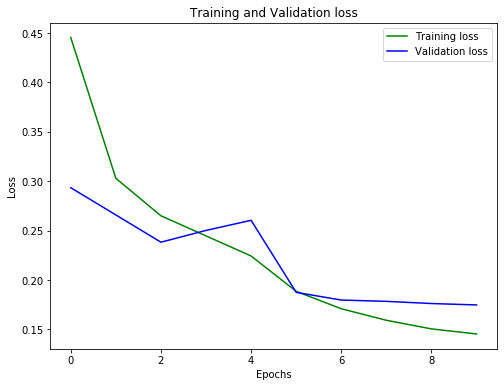

In [28]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(len(loss_train))
plt.figure(figsize = (8,6))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

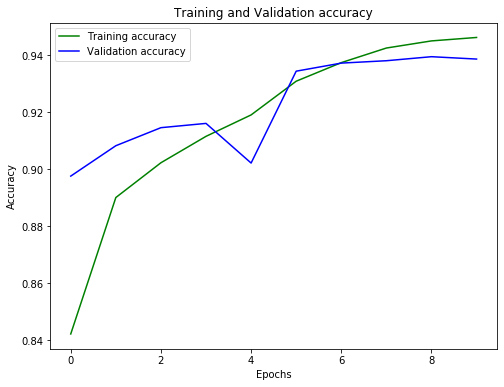

In [26]:
acc_train = history.history['acc']
acc_val = history.history['val_acc']
plt.figure(figsize = (8,6))
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_pred = advanced_model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
acc = accuracy_score(Y_true,Y_pred_classes)
class_report = classification_report(Y_true,Y_pred_classes)

print('The accuracy: {}'.format(acc))
print('The Classification Report:\n {}'.format(class_report))


The accuracy: 0.9415
The Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      1000
           1       0.99      0.99      0.99      1000
           2       0.93      0.90      0.92      1000
           3       0.94      0.95      0.95      1000
           4       0.92      0.91      0.91      1000
           5       1.00      0.98      0.99      1000
           6       0.81      0.84      0.83      1000
           7       0.96      0.97      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



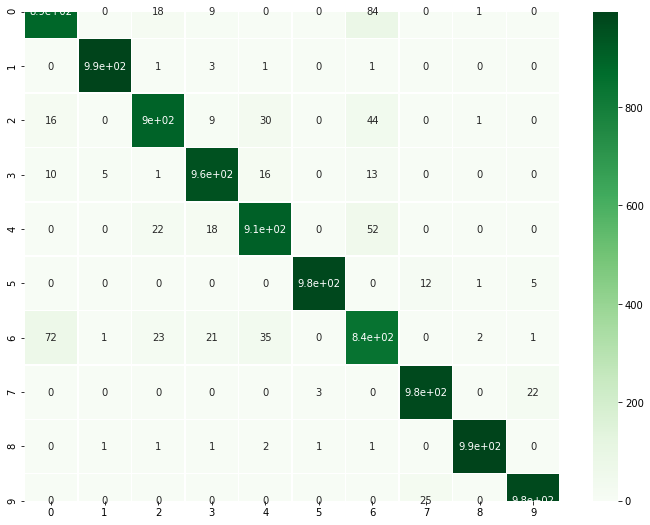

In [24]:
import seaborn as sns
cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize = (12,9))
sns.heatmap(cm, annot=True,cmap="Greens",linewidths=.5)